In [1]:
from dataclasses import dataclass
from typing import Literal, Optional, List, Dict, Any
from pathlib import Path

import pandas as pd
from PIL import Image

# Hugging Face datasets is only needed for source="huggingface"
try:
    from datasets import load_dataset
except ImportError:
    load_dataset = None


@dataclass
class RocoConfig:
    """
    Configuration for loading ROCOv2 / ImageCLEF Caption data.

    - source="huggingface": use eltorio/ROCOv2-radiology
    - source="local": use official CSVs + image folders
    """
    source: Literal["huggingface", "local"] = "huggingface"

    # Common
    split: Literal["train", "validation", "test"] = "train"

    # HF-specific
    hf_name: str = "eltorio/ROCOv2-radiology"

    # Local-specific
    data_dir: Optional[Path] = None       # /path/to/roco
    captions_file: Optional[str] = None   # e.g. "train_captions.csv"
    concepts_file: Optional[str] = None   # e.g. "train_concepts.csv"
    image_root: Optional[str] = None      # e.g. "train_images"
    cui_map_file: Optional[str] = None    # e.g. "cui_mapping.csv"


class RocoDataset:
    """
    Unified dataset:
    __getitem__ returns a dict with:
        {
          "image": PIL.Image.Image,
          "caption": str,
          "concepts": List[str],      # list of CUIs
          "image_id": str,
          "meta": Dict[str, Any],     # extra info (e.g. raw row)
          "explanation": None         # placeholder for explainability task
        }
    """

    def __init__(self, cfg: RocoConfig):
        self.cfg = cfg

        if cfg.source == "huggingface":
            self._init_hf()
        elif cfg.source == "local":
            self._init_local()
        else:
            raise ValueError(f"Unknown source: {cfg.source}")


    def _init_hf(self):
        if load_dataset is None:
            raise ImportError(
                "datasets is not installed. Run `pip install datasets`."
            )

        self.ds = load_dataset(self.cfg.hf_name)[self.cfg.split]
        # HF schema: { "image", "caption", "cui", "image_id", ... } :contentReference[oaicite:0]{index=0}

        self.backend = "huggingface"


    def _init_local(self):
        if self.cfg.data_dir is None:
            raise ValueError("data_dir must be set for source='local'.")

        data_dir = Path(self.cfg.data_dir)

        # If user didn't specify file names, infer them from split
        split = self.cfg.split  # "train", "validation", "test"
        captions_file = self.cfg.captions_file or f"{split}_captions.csv"
        concepts_file = self.cfg.concepts_file or f"{split}_concepts.csv"
        image_root = self.cfg.image_root or f"{split}_images"

        self.image_root = data_dir / image_root

        # Load CSVs
        captions_df = pd.read_csv(data_dir / captions_file)
        concepts_df = pd.read_csv(data_dir / concepts_file)

        # We assume concepts_df has columns ["image_id", "cui"] (1 CUI per row)
        # If your file is different, tweak this grouping.
        concepts_grouped = (
            concepts_df.groupby("image_id")["cui"]
            .apply(list)
            .reset_index()
        )

        df = captions_df.merge(concepts_grouped, on="image_id", how="left")

        # If 'cui' is missing for some images, fill with empty list
        df["cui"] = df["cui"].apply(lambda x: x if isinstance(x, list) else [])

        self.df = df.reset_index(drop=True)
        self.backend = "local"

        # Optional: load CUI → name mapping if available
        self.cui_to_name: Optional[Dict[str, str]] = None
        if self.cfg.cui_map_file is not None:
            cui_map_path = data_dir / self.cfg.cui_map_file
            if cui_map_path.exists():
                cui_map_df = pd.read_csv(cui_map_path)
                # Adjust column names if needed
                if "cui" in cui_map_df.columns and "preferred_label" in cui_map_df.columns:
                    self.cui_to_name = dict(
                        zip(cui_map_df["cui"], cui_map_df["preferred_label"])
                    )

    def __len__(self):
        if self.backend == "huggingface":
            return len(self.ds)
        else:
            return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        if self.backend == "huggingface":
            row = self.ds[idx]
            image = row["image"]              # PIL.Image
            caption = row["caption"]
            concepts = row.get("cui", [])     # list of CUIs
            image_id = row.get("image_id", str(idx))
            meta = {k: v for k, v in row.items() if k not in ["image"]}
        else:
            row = self.df.iloc[idx]
            image_id = row["image_id"]
            caption = row["caption"]
            concepts = row["cui"]             # list of CUIs
            img_path_jpg = self.image_root / f"{image_id}.jpg"
            img_path_png = self.image_root / f"{image_id}.png"

            if img_path_jpg.exists():
                img_path = img_path_jpg
            elif img_path_png.exists():
                img_path = img_path_png
            else:
                raise FileNotFoundError(f"Image not found for {image_id}")

            image = Image.open(img_path).convert("RGB")
            meta = row.to_dict()

        sample = {
            "image": image,
            "caption": caption,
            "concepts": concepts,
            "image_id": image_id,
            "meta": meta,
            # The dataset does NOT ship explicit explanation labels;
            # this is where *your* model's explanation can be stored.
            "explanation": None,
        }
        return sample

/Users/yashwanth/Documents/OMSCS/Deep_Learning/dl_project_fall_2025/dl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num samples: 9927
Image ID: ROCOv2_2023_test_001310
Caption : Computed tomography without contrast of the chest in transverse view. Black arrow indicates left anterior chest wall abscess.
CUIs    : ['C0040405']


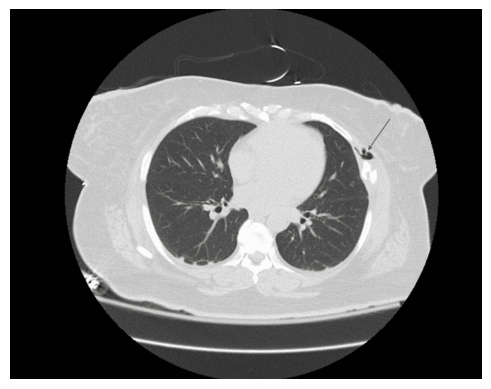

In [15]:
from pathlib import Path
import matplotlib.pyplot as plt

cfg = RocoConfig(
    source="huggingface",
    split="test",           # "train" / "validation" / "test"
)

dataset = RocoDataset(cfg)
print("Num samples:", len(dataset))

sample = dataset[1304]

print("Image ID:", sample["image_id"])
print("Caption :", sample["caption"])
print("CUIs    :", sample["concepts"])

plt.imshow(sample["image"])
plt.axis("off")
plt.show()